In [0]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import math
import time

import tensorflow as tf
import datetime



In [209]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
# Hyperparameters
nbEpochs = 50
train_batch_size = 128
test_batch_size = 128
dropoutChance = 0.5
lossControlPenalty = 0.7 # controlPenalty = 0.4...0.7
source = "SVHN"
target = "MNIST"
sourceChannels = 1
learningRate = 1e-4
dataPath = os.path.dirname(os.getcwd()) + "/data/"
log_dir = os.path.dirname(os.getcwd()) + "/logs/"
randomSeed = 1905

In [211]:
np.random.seed(randomSeed)
torch.manual_seed(randomSeed)

**TEXT**

In [0]:
class GaussianDenoising:
    """Distort a pixel with additive [+ N(0,scale)] or multiplicative [x N(1,scale)] gaussian noise"""

    def __init__(self, sigma = 0.2, effectType = "additive"):
        self.sigma = sigma
        self.effectType = effectType

    def __call__(self, x):
        if effectType == "multiplicative":
            return x.numpy() * np.random.normal(loc = 1.0, scale = sigma, size = x.shape)
        elif effectType == "additive":
            return x.numpy + np.random.normal(loc = 0.0, scale = sigma, size = x.shape)
        else:
            print("Specify a valid type of gaussian error: multiplicative or additive")
            raise ValueError

In [0]:
class ImpulseDenoising:
    """Erase a pixel with probability p"""

    def __init__(self, p = 0.5):
        self.p = p

    def __call__(self, x):
        return x.numpy() * np.random.binomial(1, self.p, size=x.shape)

In [0]:
# Data Transforms
# Data Augmentation - Geometric Transformations
# 20º random rotation
# 20% random height and width shifts
dataAugmentTransforms = []
dataAugmentTransforms.append(torchvision.transforms.RandomAffine(degrees = 20, translate = (0.2, 0.2)))
# Denoising
dataAugmentTransforms.append(torchvision.transforms.ToTensor())
dataAugmentTransforms.append(torchvision.transforms.Normalize(0.5,0.5))
dataAugmentTransforms.append(ImpulseDenoising())


MNIST_Transforms = []
MNIST_Transforms.append(torchvision.transforms.Resize((32,32), interpolation = 2)) #Rescale to SVHN size

SVHN_Transforms = []
SVHN_Transforms.append(torchvision.transforms.Grayscale())

In [219]:
train_MNIST_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.MNIST(dataPath, \
                train = True, download = True, \
                transform = torchvision.transforms.Compose\
                (MNIST_Transforms + dataAugmentTransforms)), batch_size = train_batch_size, shuffle = True)

test_MNIST_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.MNIST(dataPath, \
                train = False, download = True, \
                transform = torchvision.transforms.Compose\
                (MNIST_Transforms + [torchvision.transforms.ToTensor()])), batch_size = test_batch_size, shuffle = True)

#DataLoader has irregular behaviour, does not autom create an SVHN folder but does so for MNIST
train_SVHN_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.SVHN(dataPath + "SVHN/", \
                split = "train", download = True, \
                transform = torchvision.transforms.Compose\
                (SVHN_Transforms + dataAugmentTransforms)), batch_size = train_batch_size, shuffle = True)

test_SVHN_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.SVHN(dataPath + "SVHN/", \
                split = "test", download = True , \
                 transform = torchvision.transforms.Compose \
                (SVHN_Transforms + [torchvision.transforms.ToTensor()])), batch_size = test_batch_size, shuffle = True)


Using downloaded and verified file: //data/SVHN/train_32x32.mat
Using downloaded and verified file: //data/SVHN/test_32x32.mat


In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = [16,9]    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Source Domain batch


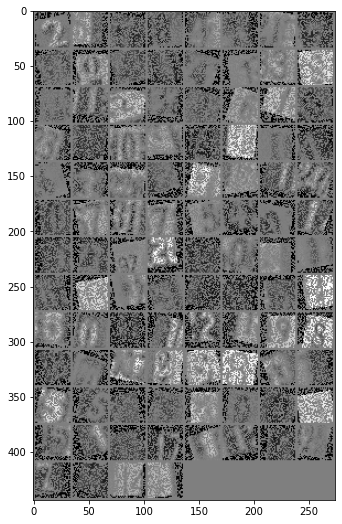

Target Domain batch


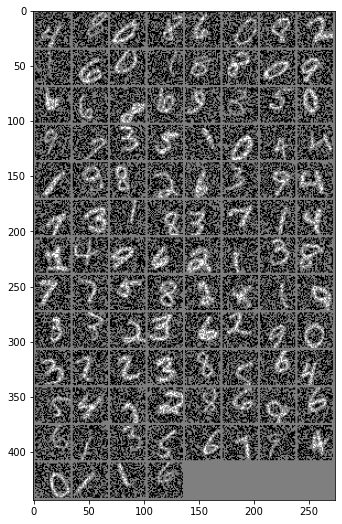

In [221]:
# get some random training images from source
batch_id, (images, labels) = next(enumerate(train_SVHN_loader))

print('Source Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))

# get some random training images from target
batch_id, (images, labels) = next(enumerate(train_MNIST_loader))

print('Target Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
def calcConvSamePadding(input, convNet, nDim = 2):
  """ Calculates padding required for convNet to produce output of same dimensions as input """
  pad_h = math.ceil((convNet.kernel_size[0] - input.shape[2] * (1 - convNet.stride[0]) - convNet.stride[0]) / 2)
  pad_w = math.ceil((convNet.kernel_size[1] - input.shape[3] * (1 - convNet.stride[1]) - convNet.stride[1]) / 2)
  return (pad_h, pad_h, pad_w, pad_w)

def calcPoolSamePadding(input, poolNet, nDim = 2): 
  """ Calculates padding required for poolNet to produce output of same dimensions as input """
  pad_h = math.ceil(((input.shape[2] - 1)*poolNet.stride[0] + 1 + poolNet.dilation*(poolNet.kernel_size[0] - 1) - input.shape[2])/2)
  pad_w = math.ceil(((input.shape[3] - 1)*poolNet.stride[1] + 1 + poolNet.dilation*(poolNet.kernel_size[1] - 1) - input.shape[3])/2)
  return (pad_h, pad_h, pad_w, pad_w)

In [0]:
def calcConvOutputDimensions(inputDim, kernelSize, padding = (0,0), dilation = (1,1), stride = (1,1)):
    """ Calculates the output dimensions from a convolutional layer with the given parameters """
    variables = [inputDim, kernelSize, padding, dilation, stride]
    for i, elem in enumerate(variables):
        if isinstance(elem, int):
            variables[i] = (elem, elem)
        elif isinstance(elem, tuple):
            pass
        else:
            raise ValueError
    Hout = math.floor((variables[0][0] + 2*variables[2][0] - variables[3][0]*(variables[1][0] - 1) -1)/variables[4][0] + 1)
    Wout = math.floor((variables[0][1] + 2*variables[2][1] - variables[3][1]*(variables[1][1] - 1) -1)/variables[4][1] + 1)
    return (Hout, Wout)

def calcPoolOutputDimensions(inputDim, pooling):
    """ Calculates the output dimensions from a convolutional layer with the given parameters """
    variables = [inputDim, pooling]
    for i, elem in enumerate(variables):
        if isinstance(elem, int):
            variables[i] = (elem, elem)
        elif isinstance(elem, tuple):
            pass
        else:
            raise ValueError
    if len(inputDim) != len(pooling):
        raise ValueError
    return tuple(int(inputDim[i]/pooling[i]) for i,ti in enumerate(pooling) )


In [0]:
# Models
class Encoder(nn.Module):
    """Encoder common to Autoencoder and labeller"""

    def __init__(self, inputChannels, dropoutChance = 0.5):
        """Initialize DomainRegressor."""
        super(Encoder, self).__init__()
        
        #Size Parameters
        
        conv1Filters = 100
        conv1KernelSize = 3
        
        maxPool1Size = (2,2)
        
        conv2Filters = 150
        conv2KernelSize = 3
        
        maxPool2Size = (2,2)
        
        conv3Filters = 200
        conv3KernelSize = 3
        
        # Placeholder ranges
#         fc4OutputSize = range(300,1000,50)
#         fc5OutputSize = range(300,1000,50)
        fc4OutputDim = 1000
        fc5OutputDim = 1000
        
        
        # Convolutional Layers Size Calculations
        conv1InputChannels = inputChannels
        conv2InputChannels = conv1Filters
        conv3InputChannels = conv2Filters
                
        # Convolutional Layers
        self.conv1 = nn.Conv2d(conv1InputChannels, conv1Filters, conv1KernelSize)      
        self.maxPool2D1 = nn.MaxPool2d(maxPool1Size)       
        self.conv2 = nn.Conv2d(conv2InputChannels, conv2Filters, conv2KernelSize)        
        self.maxPool2D2 = nn.MaxPool2d(maxPool2Size)
        self.conv3 = nn.Conv2d(conv3InputChannels, conv3Filters, conv3KernelSize)

        fc4InputDim = conv3Filters*8*8
        fc5InputDim = fc4OutputDim
        
        # Fully connected Layers
        self.fc4 = nn.Linear(fc4InputDim, fc4OutputDim)
        self.dropout4 = nn.Dropout(p = dropoutChance)
        
        self.fc5 = nn.Linear(fc5InputDim, fc5OutputDim)
        self.dropout5 = nn.Dropout(p = dropoutChance)
        
        

    def forward(self, x):
        """Forward pass X and return probabilities of source and domain."""
        x = torch.nn.functional.pad(x, (1,1,1,1))
        x = F.relu(self.conv1(x.float()))
        x = self.maxPool2D1(x)
        
        x = torch.nn.functional.pad(x, (1,1,1,1))
        x = F.relu(self.conv2(x))
        x = self.maxPool2D2(x)

        
        x = torch.nn.functional.pad(x, (1,1,1,1))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        x = F.relu(self.fc5(x))
        x = self.dropout5(x)
        return x

In [0]:
class Labeller(nn.Module):
    """ The labeller part of the network is constituted by 
    the common Encoder plus a labelling fully connected layer"""
    def __init__(self, encoder):
        super(Labeller, self).__init__()
        self.encoder = encoder
        fc3OutputSize = 10 # for 10 possible digits
        fc3InputSize = self.encoder.fc5.out_features
        self.fcOUT = nn.Linear(fc3InputSize, fc3OutputSize)  
        
    def forward(self, x):
        x = self.encoder(x)
        return F.relu(self.fcOUT(x))

    

In [0]:
class Autoencoder(nn.Module):
    """The autoencoder is constituted by the Encoder common to
    the labeller and itself, and a decoder part that is a mirror
    image of the Encoder
    
    Layers 6 and 7 are FC layers, layers 8 through 10 are (de)convolutional layers
    
    """

    def __init__(self, encoder):
        """Initialize DomainRegressor."""
        super(Autoencoder, self).__init__()
        
        self.encoder = encoder
        
        # Size Calculations
        fc6OutputSize = self.encoder.fc5.in_features
        fc6InputSize = self.encoder.fc5.out_features
        fc7OutputSize = self.encoder.fc4.in_features
        fc7InputSize = self.encoder.fc4.out_features
        
        deconv8OutputChannels = self.encoder.conv3.out_channels
        deconv8InputChannels = self.encoder.conv3.out_channels
        deconv8KernelSize = self.encoder.conv3.kernel_size
        
        deconv9OutputChannels = self.encoder.conv3.in_channels
        deconv9InputChannels = self.encoder.conv3.out_channels
        deconv9KernelSize = self.encoder.conv3.kernel_size
        
        deconv10OutputChannels = self.encoder.conv2.in_channels
        deconv10InputChannels = self.encoder.conv2.out_channels
        deconv10KernelSize = self.encoder.conv2.kernel_size

        deconv11OutputChannels = self.encoder.conv1.in_channels
        deconv11InputChannels = self.encoder.conv1.out_channels
        deconv11KernelSize = self.encoder.conv1.kernel_size
        
        # Layers
        self.fc7 = nn.Linear(fc7InputSize, fc7OutputSize)
        self.fc6 = nn.Linear(fc6InputSize, fc6OutputSize)

        self.deconv8 = nn.Conv2d(deconv8InputChannels, deconv8OutputChannels, deconv8KernelSize)
        self.deconv9 = nn.Conv2d(deconv9InputChannels, deconv9OutputChannels, deconv9KernelSize)
        self.upsample9 = nn.Upsample(scale_factor = 2, mode = "nearest")
        self.deconv10 = nn.Conv2d(deconv10InputChannels, deconv10OutputChannels, deconv10KernelSize)
        self.upsample10 = nn.Upsample(scale_factor = 2, mode = "nearest")
        self.deconv11 = nn.Conv2d(deconv11InputChannels, deconv11OutputChannels, deconv11KernelSize)

    def forward(self, x):
        """Forward pass X and return probabilities of source and domain."""
        x = self.encoder(x)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        x = torch.reshape(x, (x.shape[0], self.deconv8.in_channels, 8, 8))
        x = torch.nn.functional.pad(x, (1,1,1,1)) # Preserve dimensionality
        x = F.relu(self.deconv8(x))
        x = torch.nn.functional.pad(x, (1,1,1,1))
        x = F.relu(self.deconv9(x))
        x = F.relu(self.upsample9(x))
        x = torch.nn.functional.pad(x, (1,1,1,1))
        x = F.relu(self.deconv10(x))
        x = F.relu(self.upsample10(x))
        x = torch.nn.functional.pad(x, (1,1,1,1))
        x = self.deconv11(x)

        return x

In [0]:
encoder = Encoder(sourceChannels, dropoutChance = dropoutChance).to(device)
labeller = Labeller(encoder).to(device)
autoencoder = Autoencoder(encoder).to(device)

In [228]:
netParams = list(labeller.parameters()) + list(autoencoder.parameters())
optimizer = "Adam"
learningRate =5e-5
print("Learning rate: {}".format(learningRate))
if(optimizer == "Adam"):
  optimizer = torch.optim.Adam(netParams, lr = 3*learningRate, eps = 1e-7)
elif(optimizer == "RMSProp"):
  optimizer = torch.optim.RMSprop(netParams, lr=learningRate, alpha=0.99, eps=1e-07, weight_decay=0.9, momentum=0, centered=False)



Learning rate: 5e-05


In [0]:
def getSettings():
  settings = {}
  settings["optimizer"] = optimizer
  settings["Epochs"] = nbEpochs
  settings["train_batch_size"] = train_batch_size
  settings["test_batch_size"] = test_batch_size
  settings["dropoutChance"] = dropoutChance
  settings["lossControlPenalty"] = lossControlPenalty
  return settings

In [0]:
def getLabellingAccuracy(dataLoader, model):
  correct = 0
  total = 0
  for batch_id, (data, target) in enumerate(dataLoader):
    data = data.to(device)
    target = target.to(device)
    forward = model(data)
    pred = torch.max(forward, 1).indices
    total += target.size(0)
    # print(total)
    correct += (pred == target).sum().item()
    # print(correct)
  return(correct, total, correct/total*100)

In [0]:
def train():
  encoder.train()
  labeller.train()
  bestTargetAccuracy = 0
  bestSourceAccuracy = 0 
  avgEpochTime = 0
  start = time.time()
  batchesVerbosity = 50
  SVHNBatches = int(73300/train_batch_size) #SVHN size
  MNISTBatches = int(60000/train_batch_size) #MNIST size
  train_summary_writer = tf.summary.create_file_writer(log_dir)
  test_summary_writer = tf.summary.create_file_writer(log_dir)
  validationPeriod = 1
  print("Training for {} epochs. Batch size {}, {} and {} batches per epoch of source and target respectively".format(nbEpochs, train_batch_size, SVHNBatches, MNISTBatches))
  for epoch in range(1, nbEpochs + 1):
      epochStart = time.time()
      print("Source")
      # for batch_id, (data, target) in enumerate(train_SVHN_loader):
      #     data = data.to(device)
      #     target = target.to(device)
      #     forward = labeller(data)
      #     labellerLoss = nn.CrossEntropyLoss()
      #     labellerLoss = lossControlPenalty * labellerLoss(forward, target)
      #     lossClone = labellerLoss.detach().cpu()
      #     with train_summary_writer.as_default():
      #         index = epoch*SVHNBatches + batch_id
      #         tf.summary.scalar('Labeller Loss', lossClone, index)
      #     if(batch_id%batchesVerbosity == 0):
      #       print("Source batch {}, epoch {}. Loss = {:.5f}".format(batch_id, epoch, lossClone))
      #     optimizer.zero_grad()
      #     labellerLoss.backward()
      #     optimizer.step()
      # print("Target")
      # for batch_id, (data, target) in enumerate(train_MNIST_loader):
      #     data = data.to(device)
      #     target = target.to(device)
      #     forward = autoencoder(data)
      #     data = torch.tensor(data, dtype = torch.double, requires_grad=True).to(device)
      #     autoencoderLoss = nn.MSELoss()
      #     autoencoderLoss = (1 - lossControlPenalty) * autoencoderLoss(forward, data)
      #     lossClone = autoencoderLoss.detach().cpu()
      #     with train_summary_writer.as_default():
      #         index = epoch*MNISTBatches + batch_id
      #         tf.summary.scalar('Autoencoder_Loss', lossClone, index)
      #     if(batch_id%batchesVerbosity == 0):
      #       print("Target batch {}, epoch {}. Loss = {:.5f}".format(batch_id, epoch, lossClone))
      #     optimizer.zero_grad()
      #     autoencoderLoss.backward()
      #     optimizer.step()
          
      epochEnd = time.time()
      avgEpochTime = (avgEpochTime*(epoch-1) + (epochEnd - epochStart)) / epoch
      print("--------------")
      print("Epoch {}/{} completed in {:.5f} minutes".format(epoch, nbEpochs, (epochEnd - epochStart)/60))
      print("{:.3f} minutes elapsed".format((epochEnd - start)/60))
      print("{:.2f} minutes remaining".format(avgEpochTime/60 * (nbEpochs - epoch)))
      print("--------------")

      if (epoch%validationPeriod == 0):
        labeller.eval()
        print("Validation run")
        print("--------------") 
        with torch.no_grad():
          (correct, total, accuracy) = getLabellingAccuracy(train_SVHN_loader, labeller)
          print("Accuracy (Train) on SVHN: {:2.2f}%".format(accuracy))
          (correct, total, accuracy) = getLabellingAccuracy(test_SVHN_loader, labeller)        
          print("Accuracy (Test) on SVHN: {:2.2f}%".format(accuracy))
          if accuracy > bestSourceAccuracy:
            print("Best accuracy on source so far!")
            bestSourceAccuracy = accuracy
            bestSourceAccuracySettings = getSettings()
          with test_summary_writer.as_default():
              tf.summary.scalar('Source_accuracy', accuracy, epoch)
          
          (correct, total, accuracy) = getLabellingAccuracy(train_MNIST_loader, labeller)
          print("Accuracy (Train) on MNIST: {:2.2f}%".format(accuracy)) 
          (correct, total, accuracy) = getLabellingAccuracy(test_MNIST_loader, labeller)
          print("Accuracy (Test) on MNIST: {:2.2f}%".format(accuracy))   
          if accuracy > bestSourceAccuracy:
            print("Best accuracy on target so far!")
            bestTargetAccuracy = accuracy
            bestTargetAccuracySettings = getSettings()
          with test_summary_writer.as_default():
            tf.summary.scalar('Target_accuracy', accuracy, epoch)
          labeller.train()
      print("--------------")
          

In [0]:
log_dir += "{}-{}, ".format(source, target) +"{} epochs, ".format(nbEpochs) + datetime.datetime.now().strftime("Date - %Y%m%d-%H%M")
train()

Training for 50 epochs. Batch size 100, 733 and 600 batches per epoch of source and target respectively
Source
--------------
Epoch 1/50 completed in 0.00000 minutes
0.000 minutes elapsed
0.00 minutes remaining
--------------
Validation run
--------------
